# EDSA Apple Prices Challenge

Imagine you are in the Fresh Produce Industry. How much stock do you have on hand? Not too little that you run out of stock when customers want to buy more. And not too much that food waste occurs. How do you set your prices? Yields from farms fluctuate by season. Should your prices then also fluctuate by season?

With this context, EDSA is challenging you to construct a regression algorithm, capable of accurately predicting how much a kilogram of Golden Delicious Apples will cost, given certain parameters.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being able to accurately determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

## Data Overview

This dataset consists of over 60 000 sales made by [Durban Fresh Produce Market](http://www.durban.gov.za/Online_Tools/Pages/Fresh_Produce_Price_Reporting.aspx). In this notebook, we use this data to predict the average price per kilogram of Golden Delicious Apples.

Below is a brief description for each data field:
- Province - Which province the produce was grown
- Container - The code for the type of container
- Size_Grade - The class of the produce according to their quality
- Weight_Kg - The total weight in kilograms
- Commodities - The type of produce, e.g. Golden Delicious Apples
- Date - The date of the sale
- Sales_Total - The total sales price
- Total_Qty_Sold - The number of produce sold
- Total_Kg_Sold - The total weight of the produce sold in kilograms
- Stock_On_Hand - The amount of produce the store has

<h1>Table of Contents</h1>
<ul>
    <li><a href="#clean">Data Cleaning</a></li>
    <li><a href="#eda">Exploratiory Data Analysis</a></li>
    <li><a href="#modeldevelopment">Model Development</a></li>
    <li><a href="#modelevaluation">Model Selection</a></li>
    <li><a href="#modelselection">Model Selection</a></li>
</ul>

In [1]:
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Model slection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Cross-validation 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Visualisations
from sklearn.tree import plot_tree
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Other
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from scipy import stats
import math
import pickle

<h1 id="#clean"> Data Cleaning   </h1>
<p>

In [2]:
# import the data
train = pd.read_csv('df-train_set.csv')
test = pd.read_csv('df-test_set.csv')

In [3]:
train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64376 entries, 0 to 64375
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          64376 non-null  object 
 1   Container         64376 non-null  object 
 2   Size_Grade        64376 non-null  object 
 3   Weight_Kg         64376 non-null  float64
 4   Commodities       64376 non-null  object 
 5   Date              64376 non-null  object 
 6   Low_Price         64376 non-null  float64
 7   High_Price        64376 non-null  float64
 8   Sales_Total       64376 non-null  float64
 9   Total_Qty_Sold    64376 non-null  int64  
 10  Total_Kg_Sold     64376 non-null  float64
 11  Stock_On_Hand     64376 non-null  int64  
 12  avg_price_per_kg  64376 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 6.4+ MB


It's better to rename the columns to just lower case letters and underscores for convenience.

In [5]:
train.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities',
       'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
       'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg'],
      dtype='object')

In [6]:
train.columns = ['province', 'container', 'size_grade', 'weight_kg', 'commodities',
       'date', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'avg_price_per_kg']
train.head()

,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


In this notebook, we only consider the average price per kg of **golden delicious** apples.

In [7]:
train = train[train['commodities']=='APPLE GOLDEN DELICIOUS']
train.head()

,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,APPLE GOLDEN DELICIOUS,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


### Identifying and Handling Missing Values and Outliers

In [8]:
train.isnull().sum()

province            0
container           0
size_grade          0
weight_kg           0
commodities         0
date                0
low_price           0
high_price          0
sales_total         0
total_qty_sold      0
total_kg_sold       0
stock_on_hand       0
avg_price_per_kg    0
dtype: int64

### Handling Outliers

Next we examine the **kurtois** and **skew**. In general, the kurtois is a statistical measure that identifies whether the tails of a given distribution contain outliers. The skew will tell us about the skewness, that is, a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.

**High kurtosis (>3)** indicates a large number of outliers and **low kurtosis (<3)** a lack of outliers. 

The table below summarizes different ranges of values of skewness. 


|   Skew Value (x)  |       Description of Data      |
|:-------------------|:---------------:|
| -0.5 < x < 0.5              |Fairly Symmetrical |
| -1 < x < -0.5 | Moderate Negative Skew  | 
| 0.5 < x < 1             | Moderate Positive Skew  | 
|       x < -1     |High Negative Skew  | 
|       x > 1  |High Positve Skew | 

In [9]:
train.skew()

weight_kg           3.328254
low_price           4.222672
high_price          3.828819
sales_total         4.250317
total_qty_sold      4.445169
total_kg_sold       5.529586
stock_on_hand       3.391815
avg_price_per_kg    0.082452
dtype: float64

In [10]:
train.kurtosis()

weight_kg            9.109698
low_price           17.073369
high_price          13.630768
sales_total         24.200524
total_qty_sold      32.338123
total_kg_sold       45.153801
stock_on_hand       14.671224
avg_price_per_kg     1.042921
dtype: float64

In [11]:
shape_before = train.shape[0]

In [12]:
train_numerical = train.loc[:, 'weight_kg':'avg_price_per_kg'].drop(columns=['commodities','date'])
train = train[(np.abs(stats.zscore(train_numerical)) < 3).all(axis=1)]

In [13]:
print("Number of ouliers removed:", shape_before - train.shape[0])

Number of ouliers removed: 239


In [14]:
train.skew()

weight_kg           0.250577
low_price           0.678135
high_price          0.424259
sales_total         2.518151
total_qty_sold      2.075943
total_kg_sold       2.280170
stock_on_hand       2.176992
avg_price_per_kg   -0.124066
dtype: float64

In [15]:
train.kurtosis()

weight_kg          -1.068424
low_price          -0.271852
high_price         -0.827616
sales_total         7.429437
total_qty_sold      4.397705
total_kg_sold       5.872929
stock_on_hand       4.927424
avg_price_per_kg   -0.067884
dtype: float64

In [16]:
train.head(3)

,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11


In [17]:
train.reset_index(inplace=True)
train.head(3)

,index,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
0,1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
1,7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
2,24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11


#### Checking and Correcting the Data Format

In [18]:
train.dtypes

index                 int64
province             object
container            object
size_grade           object
weight_kg           float64
commodities          object
date                 object
low_price           float64
high_price          float64
sales_total         float64
total_qty_sold        int64
total_kg_sold       float64
stock_on_hand         int64
avg_price_per_kg    float64
dtype: object

As we can see, the 'Date' feature is in an incorrect format. We expect it to be in a 'datetime' format, but it is in the 'object' format.

In [19]:
train['date'] = pd.to_datetime(train['date'], format="%Y.%m.%d")
train['date'].head()

0   2020-09-09
1   2020-04-14
2   2020-04-16
3   2020-05-04
4   2020-03-13
Name: date, dtype: datetime64[ns]

In [20]:
train.dtypes

index                        int64
province                    object
container                   object
size_grade                  object
weight_kg                  float64
commodities                 object
date                datetime64[ns]
low_price                  float64
high_price                 float64
sales_total                float64
total_qty_sold               int64
total_kg_sold              float64
stock_on_hand                int64
avg_price_per_kg           float64
dtype: object

As we can see, the 'Date' feature is in the correct format now.

# Exploratory Data Analysis

### Univariate Analysis: Non-Graphical

### Univariate Analysis: Graphical

### Multivariate Analysis: Non-Graphical 

### Multivariate Analysis: Graphical

### Descriptive Statistical Analysis

In [21]:
train.describe(include=['object'])

,province,container,size_grade,commodities
count,1713,1713,1713,1713
unique,7,10,10,1
top,CAPE,JE090,1S,APPLE GOLDEN DELICIOUS
freq,868,560,356,1713


Value counts is a good way of understanding how many units we have for each variable. **NB:** value_counts() works only on a pandas series, not a pandas DataFrame.

However, we can convert the value count series into a DataFrame using to_frame().

In [22]:
province_counts = train['province'].value_counts().to_frame()
province_counts.rename(columns={'province': 'value_counts'}, inplace=True)
province_counts

,value_counts
CAPE,868
W.CAPE-BERGRIVER ETC,416
EASTERN CAPE,203
WEST COAST,126
NATAL,81
TRANSVAAL,11
ORANGE FREE STATE,8


In [23]:
#renaming the index to province
province_counts.index.name = 'province'
province_counts.head()

,value_counts
province,
CAPE,868
W.CAPE-BERGRIVER ETC,416
EASTERN CAPE,203
WEST COAST,126
NATAL,81


In [24]:
size_counts = train['size_grade'].value_counts().to_frame()
size_counts.rename(columns={'size_grade': 'value_counts'}, inplace=True)
size_counts

,value_counts
1S,356
1M,299
2S,289
2M,227
1L,213
1X,164
2L,120
2X,26
2U,17
1U,2


In [25]:
container_counts = train['container'].value_counts().to_frame()
container_counts.rename(columns={'container': 'value_counts'}, inplace=True)
container_counts

,value_counts
JE090,560
M4183,546
EC120,397
JG110,84
EF120,74
AC030,30
M6125,10
DT063,6
EG140,3
M9125,3


As we can see from all these 3 value_count dataframes of 'province', 'size_grade' and 'container', the results are not skewed and hence the conclusion is that the 3 categorical features are reliable predictor variables of price. 

### Correlation and Causation

The p value is the evidence against a null hypothesis. The smaller the p-value, the stronger the evidence that you should reject the null hypothesis.

By convention, when the

- p-value is  <  0.001: we say there is strong evidence that the correlation is significant.
- the p-value is  <  0.05: there is moderate evidence that the correlation is significant.
- the p-value is  <  0.1: there is weak evidence that the correlation is significant.
- the p-value is  >  0.1: there is no evidence that the correlation is significant.

**Weight vs. Average Price per Kg**

In [26]:
pearson_coef, p_value = stats.pearsonr(train['weight_kg'], train['avg_price_per_kg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.4928595783675763  with a P-value of P = 1.5927942562763161e-105


**_Conclusion_** **:** Since the P-value is far less than 0.001, we can conclude that the p value between weight and average price per kg is statistically signifigcant although the linear relationship isn't extremely strong.

**Low Price vs. Average Price per Kg**

In [27]:
pearson_coef, p_value = stats.pearsonr(train['low_price'], train['avg_price_per_kg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.8155435142289221  with a P-value of P = 0.0


**_Conclusion_** **:** Since the P-value is far less than 0.001, we can conclude that the p value between low price and average price per kg is statistically signifigcant and the linear relationship is quite strong.

**High Price vs. Average Price per Kg**

In [28]:
pearson_coef, p_value = stats.pearsonr(train['high_price'], train['avg_price_per_kg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.7637014969995672  with a P-value of P = 0.0


**_Conclusion_** **:** Since the P-value is far less than 0.001, we can conclude that the p value between weight and average price per kg is statistically signifigcant and the linear relationship is strong.

### ANOVA 

Analysis of variance is a collection of statistical models and their associated estimation procedures used to analyze the differences among means of two or more groups. The ANOVA test from scipy.stats returns two results:

<p><b>F-test score</b>: ANOVA assumes the means of all groups are the same, calculates how much the actual means deviate from the assumption, and reports it as the F-test score. A larger score means there is a larger difference between the means.</p>

<p><b>P-value</b>:  P-value tells how statistically significant is our calculated score value.</p>

<p>If our price variable is strongly correlated with the variable we are analyzing, expect ANOVA to return a sizeable F-test score and a small p-value.</p>

**Provinces**

Since ANOVA analyzes the difference between different groups of the same variable, the groupby function will come in handy. Because the ANOVA algorithm averages the data automatically, we do not need to take the average before hand.

Let's see if different 'provinces' impact 'avg_price_per_kg.' We group the data.

In [29]:
grouped_provinces=train[['province', 'avg_price_per_kg']].groupby(['province'])
grouped_provinces.head(2)

,province,avg_price_per_kg
0,CAPE,8.51
1,CAPE,4.55
2,W.CAPE-BERGRIVER ETC,6.11
7,W.CAPE-BERGRIVER ETC,8.67
8,WEST COAST,6.15
12,EASTERN CAPE,6.74
13,NATAL,3.33
15,NATAL,3.33
20,EASTERN CAPE,8.78
42,WEST COAST,4.44


Next we use the function 'f_oneway' in the module 'stats' to obtain the **F-test score** and **P-value**.

In [30]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_provinces.get_group('CAPE')['avg_price_per_kg'], grouped_provinces.get_group('W.CAPE-BERGRIVER ETC')['avg_price_per_kg'], 
                              grouped_provinces.get_group('WEST COAST')['avg_price_per_kg'], grouped_provinces.get_group('EASTERN CAPE')['avg_price_per_kg'],
                             grouped_provinces.get_group('NATAL')['avg_price_per_kg'], grouped_provinces.get_group('TRANSVAAL')['avg_price_per_kg'],
                             grouped_provinces.get_group('ORANGE FREE STATE')['avg_price_per_kg'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 77.15336255807766 , P = 1.9364805579772194e-85


As is turns out, this is a great result, our F-value of 77.15 indicates that the between-groups variance is over 77 times the size of the within-group variance. The null hypothesis value is that variances are equal, which produces an F-value of 1; The F-test score is showing a strong correlation and the result is almost 0 and we can infer that it's amost certain that the result is statistically significant.

**Size / Grade**

In [31]:
grouped_sizes=train[['size_grade', 'avg_price_per_kg']].groupby(['size_grade'])
grouped_sizes.head(1)

,size_grade,avg_price_per_kg
0,1L,8.51
1,2M,4.55
2,2S,6.11
3,1S,4.51
5,1M,8.33
9,1X,6.84
38,2L,5.63
48,2U,5.56
76,2X,4.49
302,1U,4.38


In [32]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_sizes.get_group('1L')['avg_price_per_kg'], grouped_sizes.get_group('2M')['avg_price_per_kg'], 
                              grouped_sizes.get_group('2S')['avg_price_per_kg'], grouped_sizes.get_group('1S')['avg_price_per_kg'],
                             grouped_sizes.get_group('1M')['avg_price_per_kg'], grouped_sizes.get_group('1X')['avg_price_per_kg'],
                              grouped_sizes.get_group('2L')['avg_price_per_kg'], grouped_sizes.get_group('2U')['avg_price_per_kg'],
                              grouped_sizes.get_group('2X')['avg_price_per_kg'], grouped_sizes.get_group('1U')['avg_price_per_kg'])
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 100.58146389637793 , P = 8.894511071322435e-151


The F-test score reveals that there's a strong correlation and this is statistically significant result since the P-value << 0.001. 

**Container**

In [33]:
grouped_containers=train[['container', 'avg_price_per_kg']].groupby(['container'])
grouped_containers.head(1)

,container,avg_price_per_kg
0,M4183,8.51
1,JG110,4.55
2,JE090,6.11
5,EC120,8.33
15,AC030,3.33
33,M6125,8.00
41,EF120,9.38
132,DT063,9.52
510,M9125,5.20
629,EG140,8.14


In [34]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_containers.get_group('M4183')['avg_price_per_kg'], grouped_containers.get_group('JG110')['avg_price_per_kg'], 
                              grouped_containers.get_group('JE090')['avg_price_per_kg'], grouped_containers.get_group('EC120')['avg_price_per_kg'],
                             grouped_containers.get_group('AC030')['avg_price_per_kg'], grouped_containers.get_group('M6125')['avg_price_per_kg'],
                              grouped_containers.get_group('EF120')['avg_price_per_kg'], grouped_containers.get_group('DT063')['avg_price_per_kg'],
                              grouped_containers.get_group('M9125')['avg_price_per_kg'], grouped_containers.get_group('EG140')['avg_price_per_kg'])
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 89.41372432191392 , P = 2.305289208431111e-136


Again, the F-test score reveals that there's a strong correlation and this is statistically significant result since the P-value << 0.001.

**We may now conlude that the useful features we can use for building machine learning models are:**

- low price
- high price 
- province 
- size_grade
- container

Feeding machine learning models with variables that meaningfully affect our target variable will improve our model's prediction accuracy.

In [35]:
dummy_df = pd.get_dummies(train[["province", "size_grade", "container"]])

In [36]:
# merge with main df on key values
train = pd.concat([train, dummy_df], axis=1)
train.head()

,index,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,...,container_AC030,container_DT063,container_EC120,container_EF120,container_EG140,container_JE090,container_JG110,container_M4183,container_M6125,container_M9125
0,1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,...,0,0,0,0,0,0,0,1,0,0
1,7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,...,0,0,0,0,0,0,1,0,0,0
2,24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,...,0,0,0,0,0,1,0,0,0,0
3,40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,...,0,0,0,0,0,0,0,1,0,0
4,80,CAPE,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-03-13,55.0,55.0,4840.0,...,0,0,0,0,0,1,0,0,0,0


In [37]:
train.drop(columns=["province", "size_grade", "container"], axis=1, inplace=True)

In [38]:
train.columns

Index(['index', 'weight_kg', 'commodities', 'date', 'low_price', 'high_price',
       'sales_total', 'total_qty_sold', 'total_kg_sold', 'stock_on_hand',
       'avg_price_per_kg', 'province_CAPE', 'province_EASTERN CAPE',
       'province_NATAL', 'province_ORANGE FREE STATE', 'province_TRANSVAAL',
       'province_W.CAPE-BERGRIVER ETC', 'province_WEST COAST', 'size_grade_1L',
       'size_grade_1M', 'size_grade_1S', 'size_grade_1U', 'size_grade_1X',
       'size_grade_2L', 'size_grade_2M', 'size_grade_2S', 'size_grade_2U',
       'size_grade_2X', 'container_AC030', 'container_DT063',
       'container_EC120', 'container_EF120', 'container_EG140',
       'container_JE090', 'container_JG110', 'container_M4183',
       'container_M6125', 'container_M9125'],
      dtype='object')

### Feature Engineering

In [39]:
#Baseline Model
baseline= RandomForestRegressor(criterion="mse", random_state=0)

#### Cross-Validation Score

In [40]:
rmse_cross_neg = cross_val_score(baseline, train[['low_price', 'high_price']], 
                                train['avg_price_per_kg'], cv=5, scoring='neg_mean_squared_error')

rmse_baseline = - 1 * rmse_cross_neg 
rmse_baseline

array([0.65426139, 0.68676272, 0.74118664, 0.79789441, 0.78872327])

In [41]:
print("The mean of the cross-validation folds is ", rmse_baseline.mean(), "and the standard deviation is ", rmse_baseline.std())

The mean of the cross-validation folds is  0.7337656848750849 and the standard deviation is  0.05606801454461755


From the supply and demand economic model, we may expect that if the demand of golden delicious apples is low and the supply is high, then average price of the apples will be low and viceversa. What we need is a way to quantify the demand and supply in terms of the given features.

We expect that the **more** the quantity that's sold, the _**higher** the supply_ and the _**lower** the demand_. The **less** the quatity that's sold, the _**higher** the demand_ and the _**lower** the supply_.

One way companies determine how to price their goods is to look at the demand curve and calculate the potential revenue and profit at various prices and quantities:

$(Revenue)=(Quantity Sold)×(Price)$.
                                              
So it seems plausible that a ratio of our `'sales_total'` and `'total_qty_sold'` might give us and idea about the price of apples. We may also try to include the `'weight_kg'` feature, since our target variable has units of kg as well.

In [42]:
train['price_kg'] = train['sales_total'] * train['weight_kg'] / train['total_qty_sold']  

Since most of the values in our data set are from the year 2020, we may therefore try to seek a pattern of the month and the average price per kg. Intuitively, one might expect less apples purchased during strict lockdown levels implemented by the South African government during the pandemic. 

In [43]:
train['month'] = train['date'].dt.month

In [44]:
model = RandomForestRegressor(criterion="mse", random_state=0)

In [45]:
rmse_cross_neg = cross_val_score(model, train[[ 'low_price', 'high_price', 'month', 'price_kg']], 
                                train['avg_price_per_kg'], cv=5, scoring='neg_mean_squared_error')

rmse_model = - 1 * rmse_cross_neg
rmse_model

array([0.30964182, 0.19595439, 0.09707544, 0.12382364, 0.21061639])

In [46]:
print("The mean of the cross-validation folds is ", rmse_model.mean(), "and the standard deviation is ", rmse_model.std())

The mean of the cross-validation folds is  0.18742233560489646 and the standard deviation is  0.07450599461353428


There's been a huge decrease in rmse, this is evidence enough that the `month` and `price_kg` features have exposed some new information and patterns that were not caught by the model before.

<h1 id="modeldevelopment">Model Development  </h1>
<p>

<h1 id="modelevaluation">Model Evaluation  </h1>
<p>

### Training and Testing

In [47]:
y_data = train['avg_price_per_kg']
x_data = train.drop('avg_price_per_kg', axis=1)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)

In [49]:
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 257
number of training samples: 1456


#### Model 1: Linear Regression

In [50]:
lre = LinearRegression()

In [51]:
lre.fit(x_train[['low_price']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
# R^2 on test data 
lre.score(x_test[['low_price']], y_test)

0.6620445797296447

In [53]:
# R^2 on train data 
lre.score(x_train[['low_price']], y_train)

0.6653390028279382

In [54]:
# Prediction using train data:
y_hat_train_1 = lre.predict(x_train[['low_price']])
y_hat_train_1[0:5]

array([6.00460268, 6.45430527, 8.25311563, 5.25509836, 6.37935484])

In [55]:
# Prediction using test data:
y_hat_test_1 = lre.predict(x_test[['low_price']])
y_hat_test_1[0:5]

array([ 6.00460268, 10.50162858,  5.44247444,  6.00460268,  5.25509836])

In [56]:
# RSME on training data 
train_rmse = math.sqrt(mean_squared_error(y_train, y_hat_train_1))
train_rmse

1.1912890652778827

In [57]:
#RSME on test data
test_rsme = math.sqrt(mean_squared_error(y_test, y_hat_test_1))
test_rsme

1.2878230274178561

#### Model 2: Multiple Linear Regression

The following function does the previous steps of model 1. Since the process becomes quit repetitive. We just have to instantiate the model's object and pass it into the function along with the specified x_train and x_test data.

In [58]:
def train_and_eval (model, X_train, X_test, Y_train = y_train, Y_test = y_test):
    # fit model to data/train model
    model.fit(X_train, Y_train) 
    # prediction on train data
    Yhat_train = model.predict(X_train)
    # prediction on test data
    Yhat_test = model.predict(X_test)
    # train rmse 
    rmse_train = math.sqrt(mean_squared_error(Y_train, Yhat_train))
    # test rmse 
    rmse_test = math.sqrt(mean_squared_error(Y_test, Yhat_test))
    estimates_dict = {'R^2 on train data': [model.score(X_train, Y_train)], 'R^2 on test data': [model.score(X_test, Y_test)],
                     'RMSE on train data': [rmse_train], 'RMSE on test data': [rmse_test]}
    estimates_df = pd.DataFrame(estimates_dict, index = ['Metric Value'])
    return estimates_df

In [59]:
lre_multiple = LinearRegression()

In [60]:
train_and_eval(lre_multiple, x_train[['low_price', 'high_price', 'price_kg']], x_test[['low_price', 'high_price', 'price_kg']])

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.752957,0.736162,1.02353,1.137876


#### Model 3: Polynomial Regression

Here we simply use a pipeline instead of our 'train_and_eval' function. Since the polynomial regression object has no .fit() method which is within our defined function.

In [61]:
from sklearn.pipeline import Pipeline

In [62]:
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model',LinearRegression())]
pipe=Pipeline(Input)
pipe

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [63]:
pipe.fit(x_train[['low_price', 'high_price', 'month', 'price_kg']], y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [64]:
# prediction on train
ypipe_train=pipe.predict(x_train[['low_price', 'high_price', 'month', 'price_kg']])
ypipe_train[0:4]

array([6.45993182, 6.36394764, 9.69013202, 5.30188077])

In [65]:
# prediction on test
ypipe_test=pipe.predict(x_test[['low_price', 'high_price', 'month', 'price_kg']])
ypipe_test[0:4]

array([ 5.8042488 , 10.42190422,  5.85009441,  6.39754235])

In [66]:
metrics_dict = {'R^2 on train data': [r2_score(y_train, ypipe_train)], 'R^2 on test data': [r2_score(y_test, ypipe_test)],
                     'RMSE on train data': [math.sqrt(mean_squared_error(y_train , ypipe_train))], 
                'RMSE on test data': [math.sqrt(mean_squared_error(y_test, ypipe_test))]}
metrics_df = pd.DataFrame(metrics_dict, index = ['Metric Value'])
metrics_df

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.875287,0.873111,0.727226,0.789113


Text(0.5, 1.0, 'R^2 Using Test Data')

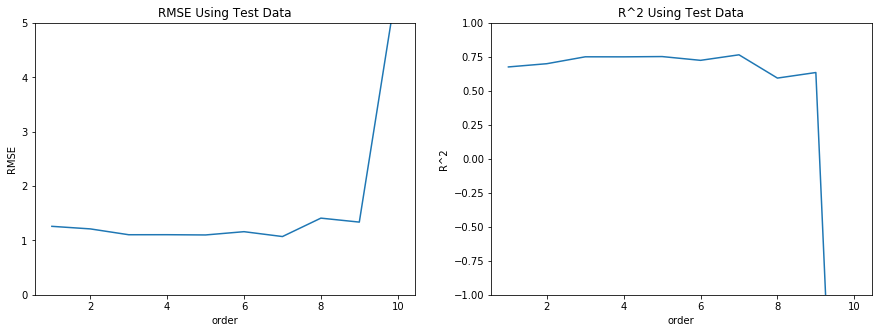

In [67]:
rmse_test = []
rsqd_test = []
order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n in order:
    Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=n, include_bias=False)), ('model',LinearRegression())]
    pipe=Pipeline(Input)
    pipe.fit(x_train[['low_price', 'high_price']], y_train)
    ypipe_test = pipe.predict(x_test[['low_price', 'high_price']])
    rmse_test.append(math.sqrt(mean_squared_error(y_test , ypipe_test)))
    rsqd_test.append(r2_score(y_test, ypipe_test))

# Create figure and axes
f, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2, sharey=False)

# Create list of titles
title = ['RMSE Using Test Data','R^2 Using Test Data']

# Plot the subplots
ax[0].set_ylim([0, 5])
ax[0].set_xlabel('order')
ax[0].set_ylabel('RMSE')
ax[0].plot(order, rmse_test)
ax[0].set_title(title[0])

ax[1].set_ylim([-1, 1])
ax[1].set_xlabel('order')
ax[1].set_ylabel('R^2')
ax[1].plot(order, rsqd_test)
ax[1].set_title(title[1])

Clearly the polynomial of degree four will minimize the RMSE on test data and maximize the R$^{2}$ as well.

#### Model 4: Decision Tree

In [68]:
dtr= DecisionTreeRegressor(max_depth=5, random_state=42)

In [69]:
train_and_eval(dtr, x_train[['low_price', 'high_price', 'month', 'price_kg']], x_test[['low_price', 'high_price', 'month', 'price_kg']])

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.91308,0.911106,0.607121,0.660485


#### Model 5: Random Forests

In [70]:
rf = RandomForestRegressor(n_estimators=500, max_depth=5)

In [71]:
train_and_eval(rf, x_train[['low_price', 'high_price', 'month', 'price_kg']], x_test[['low_price', 'high_price', 'month', 'price_kg']])

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.93498,0.926059,0.525095,0.602376


#### Model 6: Support Vector Regressor

In [72]:
sv_reg = SVR(kernel='rbf', gamma='auto')

In [73]:
train_and_eval(sv_reg, x_train[['low_price', 'high_price', 'month', 'price_kg']], x_test[['low_price', 'high_price', 'month', 'price_kg']])

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.781909,0.405293,0.961686,1.708355


#### Model 7: XGBoost

In [74]:
my_model = XGBRegressor()
my_model.fit(x_train[['low_price', 'high_price', 'month', 'price_kg']], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [75]:
predictions = my_model.predict(x_test[['low_price', 'high_price', 'month', 'price_kg']])
print("Mean Squared Error: " + str(mean_squared_error(predictions, y_test)))

Mean Squared Error: 0.11670923069331267


C:\Users\vnbri\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [76]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(x_train[['low_price', 'high_price', 'month', 'price_kg']], y_train, 
             early_stopping_rounds=5, 
             eval_set=[(x_test[['low_price', 'high_price', 'month', 'price_kg']], y_test)],
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [77]:
predictions = my_model.predict(x_test[['low_price', 'high_price', 'month', 'price_kg']])
print("Mean Squared Error: " + str(mean_squared_error(predictions, y_test)))

Mean Squared Error: 0.10990673905153425


C:\Users\vnbri\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


#### Ensemble Learning 

In [78]:
from sklearn.ensemble import VotingRegressor

In [79]:
models = [("LR",lre),("DT",dtr),("SVR",sv_reg)]

In [80]:
model_weightings = np.array([0.1,0.3,0.6])
v_reg = VotingRegressor(estimators=models,weights=model_weightings)

At this point, we have built a voting-based ensemble that combines:
- 10% of Linear Regression model output
- 30% of Decision Tree output
- 60% of Support Vector Regression output

to make a final prediction.

In [81]:
v_reg.fit(x_train[['low_price', 'high_price']], y_train)

VotingRegressor(estimators=[('LR',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False)),
                            ('DT',
                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse', max_depth=5,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                 

In [82]:
train_and_eval(v_reg, x_train[['low_price', 'high_price']], x_test[['low_price', 'high_price']] )

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.846447,0.78693,0.806944,1.022558


In [83]:
# dictionary of results
results_dict = {'Training MSE':
                    {
                        "Linear Regression": 1,
                        "Multiple Linear Regression": 2,
                        "Polynomial Regression": 3,
                        "Decision Tree": 4,
                        "Support Vector Regressor": 5,
                        "Random Forest": 6                       
                    },
                'Test MSE':
                    {
                        "Linear Regression": 7,
                        "Multiple Linear Regression": 8,
                        "Polynomial Regression": 9,
                        "Decision Tree": 10,
                        "Support Vector Regressor": 11,
                        "Random Forest": 12  
                    },
                'Test RMSE':
                    {
                        "Linear Regression": 13,
                        "Multiple Linear Regression": 14,
                        "Polynomial Regression": 15,
                        "Decision Tree": 16,
                        "Support Vector Regressor": 17,
                        "Random Forest": 18  
                    }
                }

In [84]:
results_df = pd.DataFrame(results_dict)
results_df

,Training MSE,Test MSE,Test RMSE
Linear Regression,1,7,13
Multiple Linear Regression,2,8,14
Polynomial Regression,3,9,15
Decision Tree,4,10,16
Support Vector Regressor,5,11,17
Random Forest,6,12,18


In [85]:
#X_ = dummy_variable_df.drop('avg_price_per_kg', axis=1)
#y_ = dummy_variable_df['avg_price_per_kg']

In [86]:
#X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size = 0.15,random_state=1)

In [87]:
#lre_dummy = LinearRegression(n_jobs=-1)

In [88]:
# Not working, TypeError

# lre_dummy.fit(X_train, Y_train)

<h1 id="modelselection">Model Selection, Overfitting and Underfitting  </h1>
<p>

### Ridge Regression

In [89]:
pr=PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train[['low_price', 'high_price']])
x_test_pr = pr.fit_transform(x_test[['low_price', 'high_price']])

In [90]:
RidgeModel=Ridge(alpha=0.1)

In [91]:
RidgeModel.fit(x_train_pr, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [92]:
yhat = RidgeModel.predict(x_test_pr)
yhat[0:5]

array([5.97833433, 9.68740075, 5.29855104, 5.97833433, 5.87349445])

In [93]:
print('The first 5 predicted values: ', yhat[0:5], '\n The actual/test values are ', y_test[0:5].values)

The first 5 predicted values:  [5.97833433 9.68740075 5.29855104 5.97833433 5.87349445] 
 The actual/test values are  [ 5.45 10.23  5.26  6.67  9.28]


In [94]:
Rsqu_test = []
Rsqu_train = []
dummy1 = []
alpha_params = 10 * np.array(range(0,1000))
for alfa in alpha_params:
    RigeModel = Ridge(alpha=alfa) 
    RigeModel.fit(x_train_pr, y_train)
    Rsqu_test.append(RigeModel.score(x_test_pr, y_test))
    Rsqu_train.append(RigeModel.score(x_train_pr, y_train))

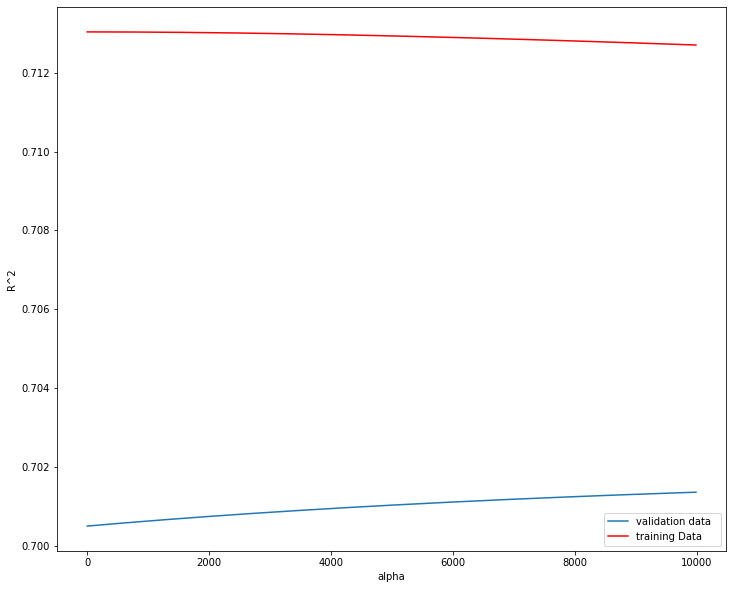

In [95]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(alpha_params,Rsqu_test, label='validation data  ')
plt.plot(alpha_params,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

### Grid Search

#### Ridge Regression

In [96]:
alpha_params1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
alpha_params1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

In [97]:
rr = Ridge()
rr

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [98]:
grid_rr = GridSearchCV(rr, alpha_params1, cv=5)

In [99]:
grid_rr.fit(x_data[['low_price', 'high_price', 'month', 'price_kg']], y_data)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [100]:
BestRR=grid_rr.best_estimator_
BestRR

Ridge(alpha=10000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [101]:
math.sqrt(mean_squared_error(y_test, BestRR.predict(x_test[['low_price', 'high_price', 'month', 'price_kg']])))

1.1386974105279093

#### Random Forest Regressor

In [102]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 40, 70, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [4, 6, 8, 10],
    'n_estimators': [200, 300, 400, 500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [103]:
grid_rf.fit(x_data[['low_price', 'high_price', 'month', 'price_kg']], y_data)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [104]:
BestRF = grid_rf.best_estimator_
BestRF

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [105]:
math.sqrt(mean_squared_error(y_test, BestRF.predict(x_test[['low_price', 'high_price', 'month', 'price_kg']])))

0.25403105405172616

# Predictions

In [106]:
test.shape

(685, 13)

In [107]:
test.isnull().sum()

Index             0
Province          0
Container         0
Size_Grade        0
Weight_Kg         0
Commodities       0
Date              0
Low_Price         0
High_Price        0
Sales_Total       0
Total_Qty_Sold    0
Total_Kg_Sold     0
Stock_On_Hand     0
dtype: int64

In [108]:
#fixing the 'Date' column in the test dataset
test['Date'] = pd.to_datetime(test['Date'], format="%Y.%m.%d") 

In [109]:
dummy_test = pd.get_dummies(test[['Province', 'Size_Grade', 'Container']])
test = pd.concat([test, dummy_test], axis=1)

In [110]:
test.drop(columns=['Province', 'Size_Grade', 'Container'], axis=1, inplace=True)

In [111]:
train.columns

Index(['index', 'weight_kg', 'commodities', 'date', 'low_price', 'high_price',
       'sales_total', 'total_qty_sold', 'total_kg_sold', 'stock_on_hand',
       'avg_price_per_kg', 'province_CAPE', 'province_EASTERN CAPE',
       'province_NATAL', 'province_ORANGE FREE STATE', 'province_TRANSVAAL',
       'province_W.CAPE-BERGRIVER ETC', 'province_WEST COAST', 'size_grade_1L',
       'size_grade_1M', 'size_grade_1S', 'size_grade_1U', 'size_grade_1X',
       'size_grade_2L', 'size_grade_2M', 'size_grade_2S', 'size_grade_2U',
       'size_grade_2X', 'container_AC030', 'container_DT063',
       'container_EC120', 'container_EF120', 'container_EG140',
       'container_JE090', 'container_JG110', 'container_M4183',
       'container_M6125', 'container_M9125', 'price_kg', 'month'],
      dtype='object')

In [112]:
test['price_kg'] = test['Sales_Total'] * test['Weight_Kg'] / test['Total_Qty_Sold']  
test['month'] = test['Date'].dt.month

In [113]:
test.columns

Index(['Index', 'Weight_Kg', 'Commodities', 'Date', 'Low_Price', 'High_Price',
       'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand',
       'Province_CAPE', 'Province_EASTERN CAPE', 'Province_NATAL',
       'Province_ORANGE FREE STATE', 'Province_TRANSVAAL',
       'Province_W.CAPE-BERGRIVER ETC', 'Province_WEST COAST', 'Size_Grade_1L',
       'Size_Grade_1M', 'Size_Grade_1S', 'Size_Grade_1U', 'Size_Grade_1X',
       'Size_Grade_2L', 'Size_Grade_2M', 'Size_Grade_2S', 'Size_Grade_2U',
       'Size_Grade_2X', 'Container_AC030', 'Container_DT063',
       'Container_EC120', 'Container_EF120', 'Container_EG140',
       'Container_IA400', 'Container_JE090', 'Container_JG110',
       'Container_M4183', 'Container_M6125', 'Container_M9125', 'price_kg',
       'month'],
      dtype='object')

In [114]:
#model = Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
#      normalize=False, random_state=None, solver='auto', tol=0.001)
model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
model.fit(train[['low_price', 'high_price', 'price_kg', 'month']], train['avg_price_per_kg'])
                
preds = model.predict(test[['Low_Price', 'High_Price', 'price_kg', 'month']])
preds[0:5]

array([10.7644245 , 12.07452349,  9.99927714,  8.73986116,  7.72816315])

# Submission

In [115]:
index = test['Index']

In [116]:
# create submission dataframe
submission = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': preds
    })

submission.head()

,Index,avg_price_per_kg
0,1,10.764425
1,2,12.074523
2,3,9.999277
3,4,8.739861
4,5,7.728163


In [117]:
#Save DataFrame to csv file for submission
submission.to_csv("15th_submission.csv", index=False)